In [13]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from dual_aperture import Aperture, Detector, run_model, PlaneWaveDetector, xp, Sample

In [14]:
import ase
import abtem
from abtem.core.energy import energy2wavelength
unit_cell = ase.build.bulk("Au", cubic=True)
atoms = unit_cell * (3, 3, 1)
potential = abtem.Potential(
    atoms,
    slice_thickness=5,
    sampling=0.02,
    projection="infinite",
)
energy_ev = 60e3
wavelength = energy2wavelength(energy_ev) * 1e-10  # m
print(wavelength)
phase_shift = potential.build().compute().transmission_function(energy_ev).compute().array[0]

4.866060479040298e-12
[########################################] | 100% Completed | 101.30 ms


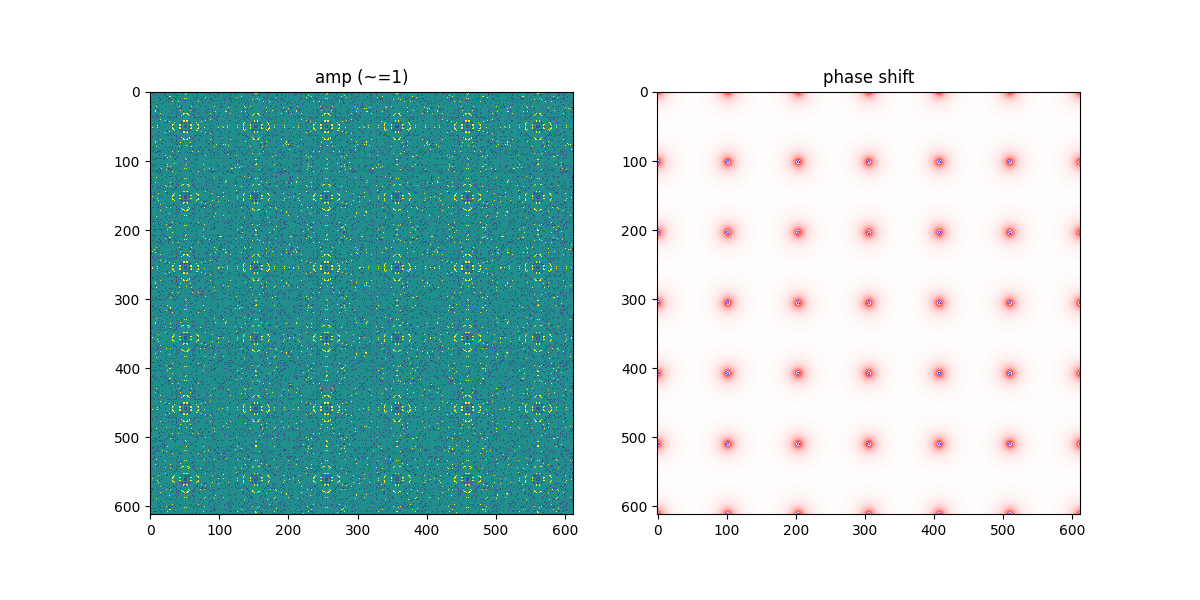

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(np.abs(phase_shift))
ax1.set_title('amp (~=1)')
ax2.imshow(np.angle(phase_shift), cmap='bwr', vmin=-np.pi, vmax=np.pi)
ax2.set_title('phase shift');

In [16]:
um = 1e-6
nm = 1e-9

if False:
    intermediate_aperture = Aperture(
        z=2500 * um, radius=100 * um, cyx=None,  #(100 * um, 100 * um)
    )
else:
    intermediate_aperture = None

num_rays = int(1e5)
print(f"wavelength = {wavelength * 1e9} nm")

wavefront = run_model(
    num_rays,
    wavelength,
    Sample(
        z=0 * nm,
        size=(3 * nm, 3 * nm),
        illuminated_r=100 * nm,
        illuminated_cyx=None, # (0.5 * nm, 0.5 * nm),
        phase_shift=xp.asarray(phase_shift),
        periodic=True,
        cutoff=1,
    ),
    # Aperture(
    #     z=125 * nm, radius=10 * nm, cyx=None,
    # ),
    None,
    Detector(
        z=2000 * nm, shape=(256, 256), size=(32 * nm, 32 * nm)
    ),
    batch_size=int(1e3),
)


wavelength = 0.004866060479040298 nm


  0%|          | 0/100 [00:00<?, ?it/s]

Text(0.5, 1.0, 'phase')

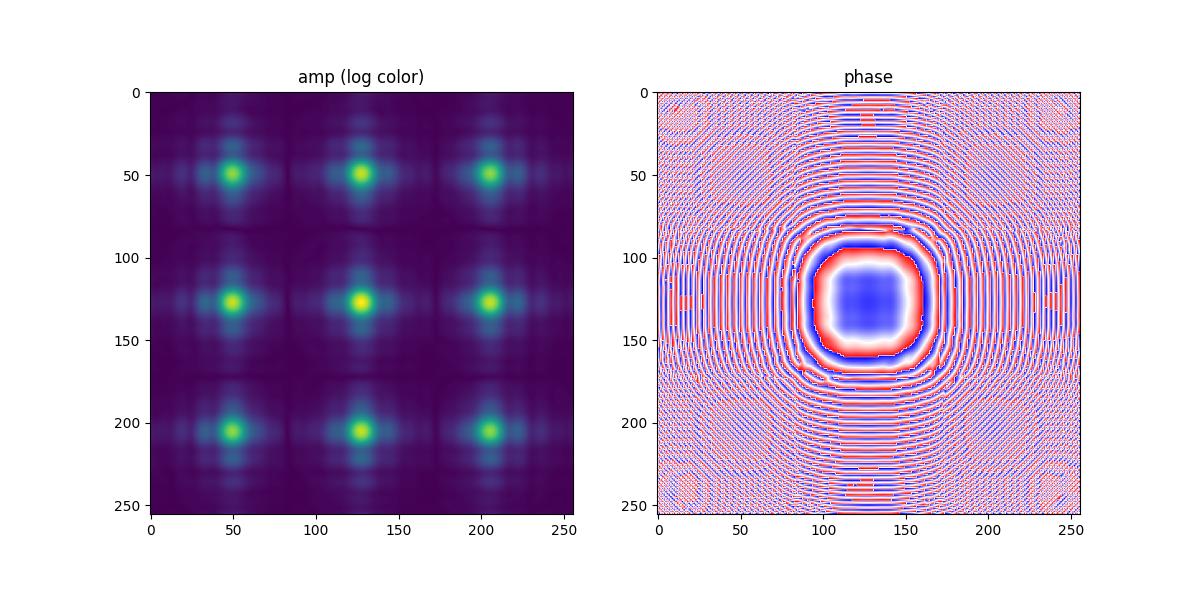

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(np.abs(wavefront))
ax1.set_title('amp (log color)')
ax2.imshow(np.angle(wavefront), cmap='bwr', vmin=-np.pi, vmax=np.pi)
ax2.set_title('phase')

In [ ]:
# # Check aperture sampling is uniform-ish
# points = Aperture(
#     z=0 * um, radius=100 * um, cyx=None,
# ).random_on(5000, np.random.RandomState())
# fig, ax1 = plt.subplots()
# ax1.plot(points[:, 0], points[:, 1], 'rx')
# ax1.axis('equal');